<a href="https://colab.research.google.com/github/mattsmiths/biol470/blob/main/week5/simpleDrosophilaTracking_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
#@title Click to import libraries
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

In [ ]:
#@title Click to copy the class code repository
!git clone https://github.com/mattsmiths/biol470.git

In [42]:
select_video = '/content/biol470/week5/fly_flood.m4v'

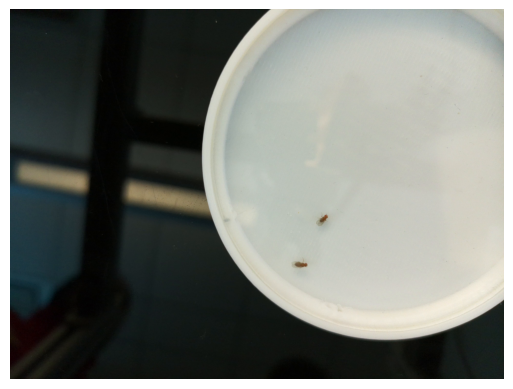

In [43]:
videoPath = select_video
in1 = cv.VideoCapture(videoPath)

readIn,frame = in1.read()
plt.imshow(frame[:,:,::-1])
plt.axis('off')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 100 D Air
# 200 C Air
# 200 B Air
# 150 A Air and drop to 1000

# Quick video processing of Drosophila behavior!

In [ ]:
Generate_Video = 'True' # @param ["True","False"]

In [ ]:
#@title Process video
print('Processing the loaded video')
kernel = np.ones((25, 25), np.uint8)  # 10x10 square kernel
tempVid = videoPath
in1 = cv.VideoCapture(tempVid)
readIn,frame = in1.read()
tN = videoPath.split('/')[-1].split('.')[0]
if os.path.isdir('/content/%s/'%tN) == False:
  os.mkdir('/content/%s/'%tN)

# Adapt threshold
if 'flyA' in videoPath:
  athresh = 150
elif 'flyB' in videoPath:
  athresh = 200
elif 'flyB' in videoPath:
  athresh = 200
elif 'flyB' in videoPath:
  athresh = 100
else:
  athresh = 120

frame_count = int(in1.get(cv.CAP_PROP_FRAME_COUNT))
frame_count = 1200
flyOut = {}

baseNan = [np.nan]*frame_count
for ff in range(0,2):
  flyOut['fly'+str(ff)+'x'] = baseNan.copy()
  flyOut['fly'+str(ff)+'y'] = baseNan.copy()

flytt = 4
readIn,image = in1.read()
elee = 0


if Generate_Video == 'True':
  tN = videoPath.split('/')[-1].split('.')[0]
  vid1 = cv.VideoWriter('/content/%s/flyTracker_%s.mp4'%(tN,tN),cv.VideoWriter_fourcc('M','J','P','G'),10,(4056,3040))

while readIn:

  tempIm = cv.cvtColor(image,cv.COLOR_BGR2GRAY) < athresh
  binaryThreshold = (tempIm).astype(np.uint8)

  # Apply erosion to remove small white noise
  eroded_mask = cv.erode(binaryThreshold, kernel, iterations=1)

  # Apply dilation to restore the shape of larger regions
  dilated_mask = cv.dilate(eroded_mask, kernel, iterations=1)


  contours, _ = cv.findContours(dilated_mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  flycnt = 0

  newFrame = []
  # Loop through each detected contour
  for contour in contours:
      # Skip small contours (less than the specified area threshold)
      #if cv.contourArea(contour) > 12000 or cv.contourArea(contour) < 1000:
      if cv.contourArea(contour) > 10000 or cv.contourArea(contour) < 200:
          continue
      x, y, w, h = cv.boundingRect(contour)
      if Generate_Video == 'True':
        cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 6)
      xx = []
      yy= []
      for ele in np.squeeze(contour):
        xx.append(ele[0])
        yy.append(ele[1])
      xx = np.nanmean(xx)
      yy = np.nanmean(yy)

      newFrame.append([float(xx),float(yy)])
      if elee == 0:
        tN = 'fly'+str(flycnt)

        #if tN+'x' not in flyOut:
        #  flyOut[tN+'x'] = []
        #  flyOut[tN+'y'] = []
        if flycnt == len(flyOut.keys())/2:
          flyOut['fly'+str(flycnt)+'x'] = baseNan.copy()
          flyOut['fly'+str(flycnt)+'y'] = baseNan.copy()
        flyOut[tN+'x'][elee] = float(xx)#.append(xx)
        flyOut[tN+'y'][elee] = float(yy)#.append(yy)
        #print(xx)
        flycnt+=1
        # Draw a rectangle around the detected green object


        oldFrame = newFrame.copy()
  if Generate_Video == 'True':
    vid1.write(image)

  if elee > 0:
    t = {}
    for ele in newFrame:
      for ee in oldFrame:
        t[str(ele)+'-'+str(ee)] = np.linalg.norm(np.array(ele)-np.array(ee))

    flyMatch = []
    flyOO = []
    while t != {}:
      ids = list(t.keys())
      #if np.nanmin(list(t.values())) > 200 or str(np.nanmin(list(t.values()))) == 'nan':
      #  break
      cc = np.nanargmin(np.array(list(t.values())))
      #print(t.values())
      tName = ids[cc].split('-')
      rr = []
      flyMatch.append(tName[0])
      flyOO.append(tName[1])
      #oldFlyM = np.nanargmax([float(bb) for bb in tName[1][1:-1].split(',')] == oldFrame)

      bb = [float(bb) for bb in tName[1][1:-1].split(',')]
      oldFlyM = np.where([bb == cc for cc in oldFrame])[0][0]

      temp = [float(bb) for bb in tName[0][1:-1].split(',')]
      tN = 'fly'+str(oldFlyM)
      flyOut[tN+'x'][elee]=temp[0]
      flyOut[tN+'y'][elee]=temp[1]


      for ele in t:
        if tName[0] in ele or tName[1] in ele:
          rr.append(ele)
      for rp in rr:
        t.pop(rp)

    for ele in newFrame:
      if str(ele) not in flyMatch:

        flyOut['fly'+str(flycnt)+'x'] = baseNan.copy()
        flyOut['fly'+str(flycnt)+'y'] = baseNan.copy()
        flyOut['fly'+str(flycnt)+'x'][elee] = ele[0]
        flyOut['fly'+str(flycnt)+'y'][elee] = ele[1]

        flycnt+=1

    #if elee == 1:
      #break
    for cctv,ele in enumerate(oldFrame):
      if str(ele) not in flyOO:
        flyOut['fly'+str(cctv)+'x'][elee] = flyOut['fly'+str(cctv)+'x'][elee-1]
        flyOut['fly'+str(cctv)+'y'][elee] = flyOut['fly'+str(cctv)+'y'][elee-1]
    #    deactivateFly
  oldFrame = []
  for ccnt,pp in enumerate(flyOut.keys()):
    if ccnt%2 == 1:continue
    oldFrame.append([flyOut[pp][elee],flyOut[list(flyOut.keys())[ccnt+1]][elee]])

  elee+=1
  #flycnt=0
  # Display the original frame with bounding boxes

  #print(oldFrame)
  readIn,image = in1.read()
in1.release()
if Generate_Video == 'True':
  vid1.release()

csvOut = pd.DataFrame.from_dict(flyOut)
tN = videoPath.split('/')[-1].split('.')[0]
csvOut.to_csv('/content/%s/position_%s.csv'%(tN,tN))

Processing the loaded video


In [ ]:
#@title Run if there was an error above
in1.release()
csvOut = pd.DataFrame.from_dict(flyOut)
tN = videoPath.split('/')[-1].split('.')[0]
csvOut.to_csv('/content/%s/position_%s.csv'%(tN,tN))

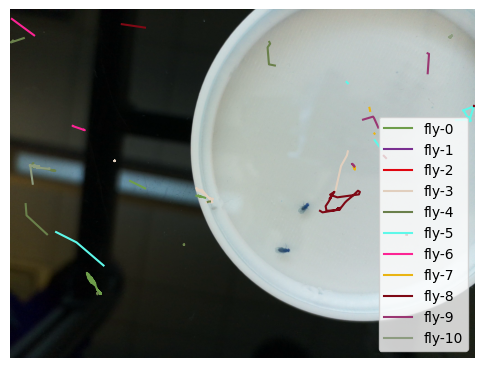

In [ ]:
#@title Generate fly track overlay

if os.path.isdir('/content/%s/'%tN) == False:
  os.mkdir('/content/%s/'%tN)

fig = plt.figure(figsize=(6,6))
plt.imshow(frame)
plt.axis('off')
cA = []
for ccnt,pp in enumerate(flyOut.keys()):
  if ccnt%2 == 1:continue
  c1 = np.random.rand(3,)
  cA.append(c1)

  for cnn, ele in enumerate(flyOut[pp]):
    if cnn == 0:continue
    if abs(flyOut[pp][cnn] - flyOut[pp][cnn-1]) > 250:
      flyOut[pp][cnn] = np.nan
      flyOut[list(flyOut.keys())[ccnt+1]][cnn] = np.nan

    if abs(flyOut[list(flyOut.keys())[ccnt+1]][cnn] - flyOut[list(flyOut.keys())[ccnt+1]][cnn-1]) > 250:
      flyOut[pp][cnn] = np.nan
      flyOut[list(flyOut.keys())[ccnt+1]][cnn] = np.nan

  plt.plot(flyOut[pp],flyOut[list(flyOut.keys())[ccnt+1]],color=c1,label='fly-%s'%(ccnt//2))
plt.legend()
plt.savefig('/content/%s/tracks_%s.pdf'%(tN,tN),dpi=300)

In [ ]:
#@title Calculate Speed
total1 = []
for cnt,flies in enumerate(flyOut.keys()):
  if cnt%2 == 1:continue

  x = flyOut[flies]
  y = flyOut[list(flyOut.keys())[cnt+1]]
  fSpd = []
  for cc,ele in enumerate(x):
    if cc == 0:continue
    spd = np.sqrt(((x[cc]-x[cc-1])**2)+((y[cc]-y[cc-1])**2))
    if spd > 250:
      fSpd.append(np.nan)
    else:
      fSpd.append(spd)

  total1.append(fSpd)

speedyFly = {}
for cnt,fly in enumerate(total1):
  tempName = 'fly_%s'%cnt
  speedyFly[tempName] = fly

csvOut = pd.DataFrame.from_dict(speedyFly)
csvOut.to_csv('/content/%s/speed_%s.csv'%(tN,tN))

/tmp/ipython-input-2961756947.py:14: RuntimeWarning: Mean of empty slice
  meann = np.nanmean(fly[ee-sWindow:ee])
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2961756947.py:14: RuntimeWarning: Mean of empty slice
  meann = np.nanmean(fly[ee-sWindow:ee])
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2961756947.py:14: RuntimeWarning: Mean of empty slice
  meann = np.nanmean(fly[ee-sWindow:ee])
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2961756947.py:14: RuntimeWarning: Mean of empty slice
  meann = np

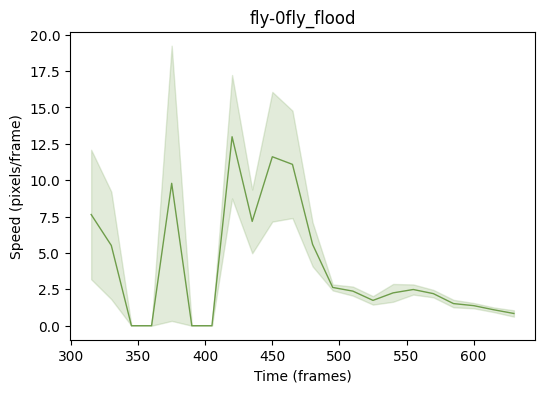

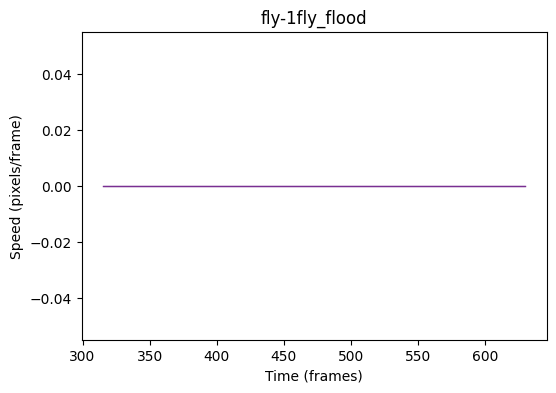

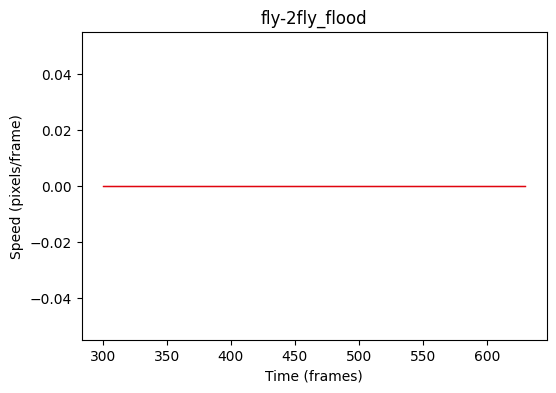

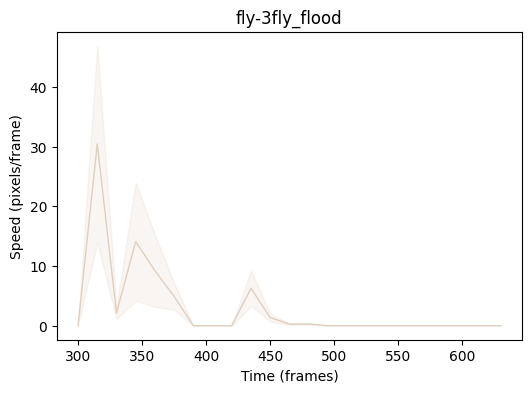

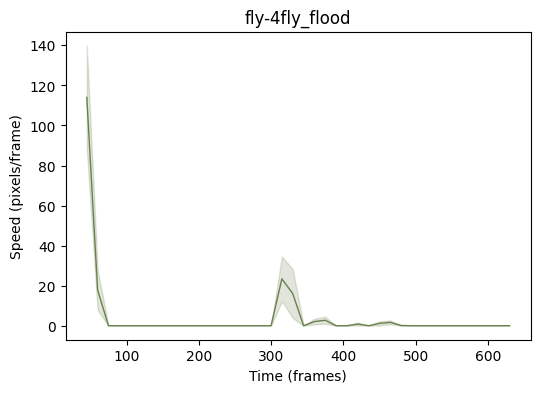

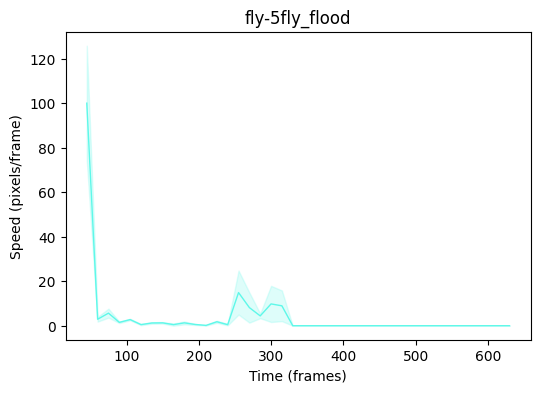

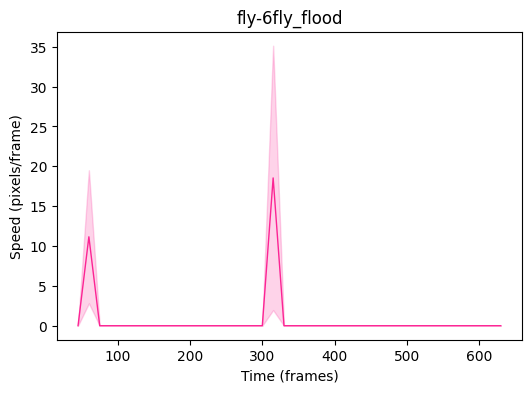

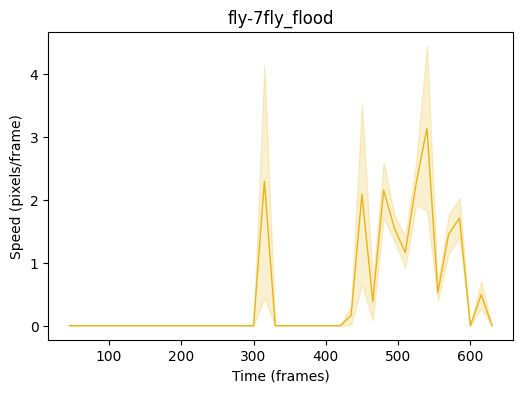

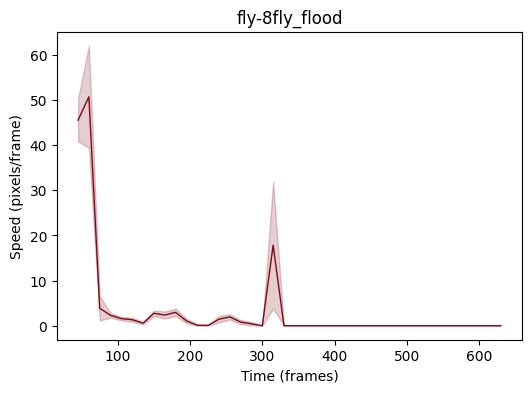

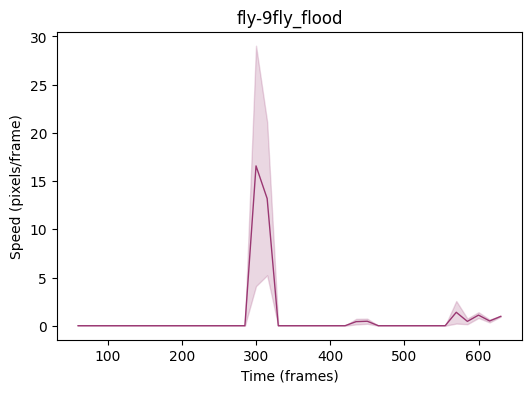

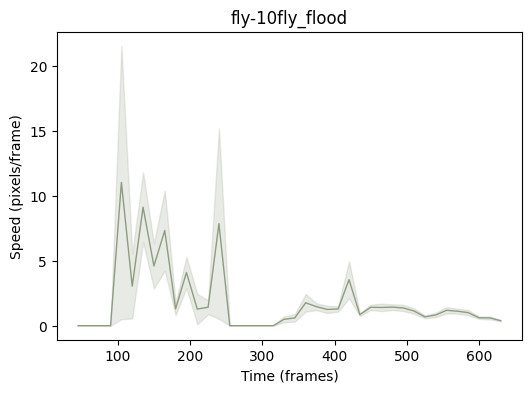

In [ ]:
#@title Plot speed per fly
if os.path.isdir('/content/%s/'%tN) == False:
  os.mkdir('/content/%s/'%tN)
for cnt,fly in enumerate(total1):
  plt.figure(figsize=(6,4))
  tempName = 'fly_%s'%cnt

  sWindow = 15

  if len(fly)> sWindow:
    mm = []
    ss = []
    for ee in np.arange(sWindow,len(fly),sWindow):
      meann = np.nanmean(fly[ee-sWindow:ee])
      stdd = np.nanstd(fly[ee-sWindow:ee])
      mse = stdd/np.sqrt(sWindow)
      mm.append(meann)
      ss.append(mse)
  if len(fly)> sWindow:
    o = plt.plot(np.arange(sWindow,len(fly),sWindow),np.array(mm),color=cA[cnt],linewidth=1)
    o =plt.fill_between(np.arange(sWindow,len(fly),sWindow),np.array(mm)-np.array(ss),np.array(mm)+np.array(ss),alpha=0.2,color=cA[cnt])
  else:
    plt.plot(fly,color=cA[cnt])

  #plt.plot(fly,color=cA[cnt])
  plt.title('fly-%s'%cnt+tN)
  plt.xlabel("Time (frames)")
  plt.ylabel("Speed (pixels/frame)")
  plt.savefig('/content/%s/fly_%s_speed_%s.pdf'%(tN,cnt,tN))

[0.55113666 0.61170682 0.50159891]
[0.55113666 0.61170682 0.50159891]
[0.55113666 0.61170682 0.50159891]
[0.55113666 0.61170682 0.50159891]
[0.55113666 0.61170682 0.50159891]
[0.55113666 0.61170682 0.50159891]
[0.55113666 0.61170682 0.50159891]
[0.55113666 0.61170682 0.50159891]
[0.55113666 0.61170682 0.50159891]
[0.55113666 0.61170682 0.50159891]
[0.55113666 0.61170682 0.50159891]


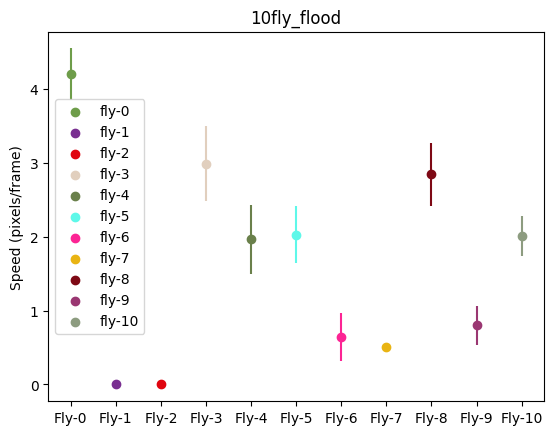

In [ ]:
#@title Scatter plot of mean speed across flies
for cnt,fly in enumerate(total1):
  tempName = 'fly_%s'%cnt
  #c1 = np.random.rand(3,)
  print(c1)
  plt.scatter(cnt, np.nanmean(fly),color=cA[cnt],label='fly-%s'%cnt)
  sem = np.nanstd(fly)/np.sqrt(len(fly))
  plt.errorbar(cnt, np.nanmean(fly),yerr=sem,color=cA[cnt])
  #plt.plot(fly,color=c1)


plt.title('%s'%cnt+tN)

nFlies = np.arange(0,cnt+1)
nnF = ['Fly-%s'%ele for ele in nFlies]
plt.xticks(nFlies,nnF)
plt.ylabel("Speed (pixels/frame)")
plt.legend()
plt.savefig('/content/%s/fly_%s_speed_%s.pdf'%(tN,cnt,tN))

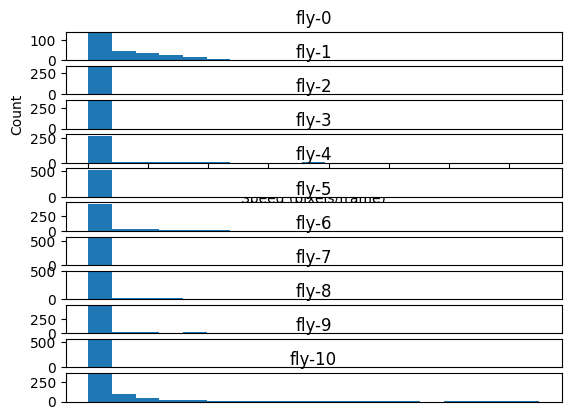

In [ ]:
#@title Histogram of flies
fig,ax = plt.subplots(len(total1),1)
for cnt,ele in enumerate(total1):
  ax[cnt].set_title('fly-%s'%cnt)
  ax[cnt].hist(ele,np.linspace(0,15,20))
  if cnt == 2:
    ax[cnt].set_ylabel("Count")
  if cnt == 3:
    ax[cnt].set_xlabel("Speed (pixels/frame)")
  else:
    ax[cnt].set_xticks([])
  #ax[cnt].set_ylabel("Speed (pixels/frame)")
plt.savefig('/content/%s/%s_hist.pdf'%(tN,tN),dpi=300)